In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

import os

import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn.preprocessing
import sklearn
from sklearn.metrics import r2_score

from keras.layers import Dense,Dropout,SimpleRNN,LSTM
from keras.models import Sequential

import seaborn as sns
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
from google.colab import files


uploaded = files.upload()


Saving tehran_energy_peakk.csv to tehran_energy_peakk.csv


In [19]:
df = pd.read_csv('tehran_energy_peakk.csv', index_col=[0], parse_dates=[0])

In [20]:
df.shape

(1096, 1)

In [25]:
#outliers
from scipy import stats
df = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]

In [26]:
df.shape

(1094, 1)

In [28]:
df.isna().sum()

peak    0
dtype: int64

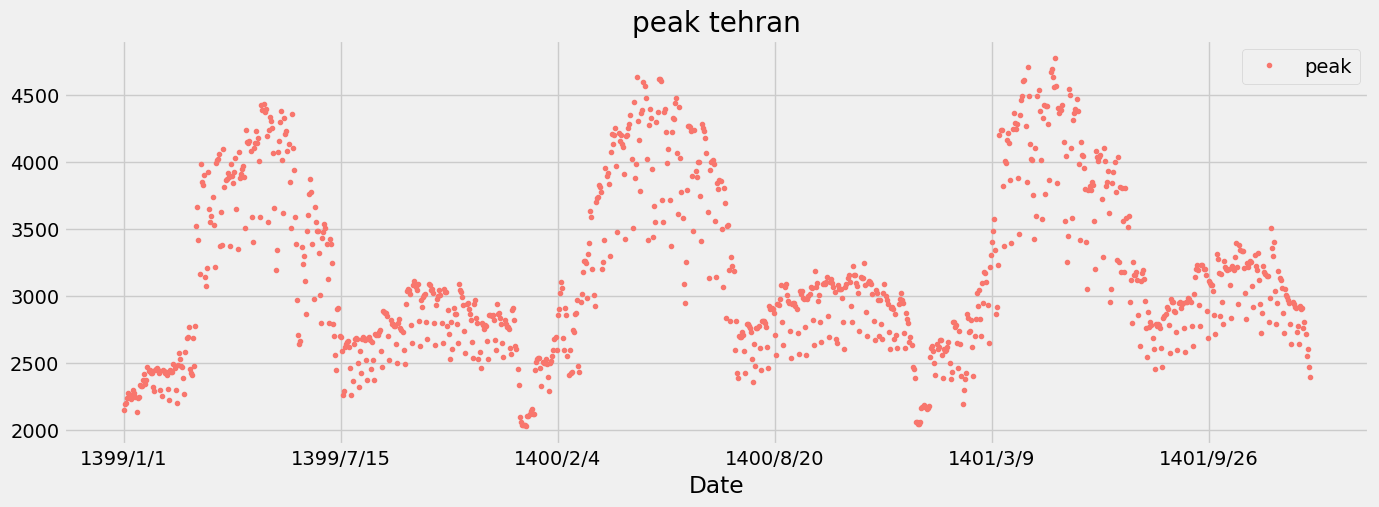

In [27]:
plotdf = df.plot(style='.', figsize=(15,5), color="#F8766D", title='peak tehran')

In [29]:
def normalize_data(df):
    scaler = sklearn.preprocessing.MinMaxScaler()
    df['peak']=scaler.fit_transform(df['peak'].values.reshape(-1,1))
    return df

df_norm = normalize_data(df)
df_norm.shape

(1094, 1)

In [30]:
df_norm.shape

(1094, 1)

In [34]:
def load_data(stock, seq_len):
    X_train = []
    y_train = []
    for i in range(seq_len, len(stock)):
        X_train.append(stock.iloc[i-seq_len : i, 0])
        y_train.append(stock.iloc[i, 0])
    
    #1 last 296 days are going to be used in test
    X_test = X_train[800:]             
    y_test = y_train[800:]
    
    #2 first 800 days are going to be used in training
    X_train = X_train[:800]           
    y_train = y_train[:800]
    #3 convert to numpy array
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    #4 reshape data to input into lstm models
    X_train = np.reshape(X_train, (800, seq_len, 1))
    
    X_test = np.reshape(X_test, (X_test.shape[0], seq_len, 1))
    
    return [X_train, y_train, X_test, y_test]

In [35]:
#create train, test data
seq_len = 20 #choose sequence length

X_train, y_train, X_test, y_test = load_data(df, seq_len)

print('X_train.shape = ',X_train.shape)
print('y_train.shape = ', y_train.shape)
print('X_test.shape = ', X_test.shape)
print('y_test.shape = ',y_test.shape)

X_train.shape =  (800, 20, 1)
y_train.shape =  (800,)
X_test.shape =  (274, 20, 1)
y_test.shape =  (274,)


In [36]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Define the LSTM model
model = Sequential()
model.add(LSTM(units=50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=24)

Epoch 1/100
34/34 [==============================] - 3s 11ms/step - loss: 0.0390
Epoch 2/100
34/34 [==============================] - 0s 12ms/step - loss: 0.0122
Epoch 3/100
34/34 [==============================] - 0s 11ms/step - loss: 0.0115
Epoch 4/100
34/34 [==============================] - 0s 13ms/step - loss: 0.0111
Epoch 5/100
34/34 [==============================] - 1s 17ms/step - loss: 0.0109
Epoch 6/100
34/34 [==============================] - 1s 17ms/step - loss: 0.0110
Epoch 7/100
34/34 [==============================] - 1s 14ms/step - loss: 0.0108
Epoch 8/100
34/34 [==============================] - 0s 12ms/step - loss: 0.0106
Epoch 9/100
34/34 [==============================] - 0s 11ms/step - loss: 0.0103
Epoch 10/100
34/34 [==============================] - 0s 10ms/step - loss: 0.0104
Epoch 11/100
34/34 [==============================] - 0s 11ms/step - loss: 0.0100
Epoch 12/100
34/34 [==============================] - 0s 10ms/step - loss: 0.0100
Epoch 13/100
34/34 [=====

In [37]:
lstm_predictions = model.predict(X_test)

lstm_score = r2_score(y_test, lstm_predictions)
print("R^2 Score of LSTM model = ",lstm_score)

9/9 [==============================] - 1s 4ms/step
R^2 Score of LSTM model =  0.8403134589849415


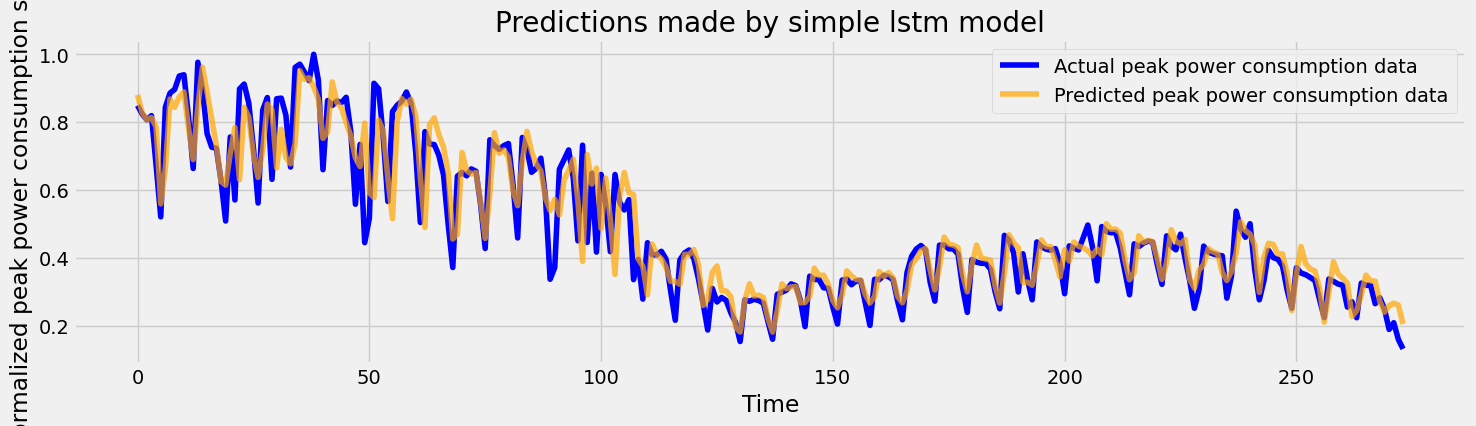

In [40]:
def plot_predictions(test, predicted, title):
    plt.figure(figsize=(16,4))
    plt.plot(test, color='blue',label='Actual peak power consumption data')
    plt.plot(predicted, alpha=0.7, color='orange',label='Predicted peak power consumption data')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Normalized peak power consumption scale')
    plt.legend()
    plt.show()
    
plot_predictions(y_test, lstm_predictions, "Predictions made by simple lstm model")